<a href="https://colab.research.google.com/github/davidogm/DataScience/blob/main/datamining/EjemplosClustering/clustering_pisos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering en pisos reales

In [ ]:
import pandas as pd

piso1=pd.read_csv('data_8.csv', sep=',' )

In [ ]:
piso1=piso1.drop(['Unnamed: 0'], axis=1)

In [ ]:
piso=piso1

In [ ]:
piso['state_bool'] = piso.state.apply(lambda q: 1 if q == 'on' else 0)


In [ ]:
piso=piso.drop('state', axis=1)

In [ ]:
piso.head()

,timestamp,id_house,id_sensor,state_bool
0,1.674048e+09,8,46,1
1,1.674048e+09,8,46,0
2,1.674048e+09,8,45,1
3,1.674048e+09,8,45,0
4,1.674053e+09,8,48,1


In [ ]:
dif_sensors_array=piso.id_sensor.unique()

In [ ]:
dif_sensors=dif_sensors_array.size

In [ ]:
piso.timestamp[4]

1674053168.999419

In [ ]:
piso_limpio=piso.drop_duplicates()

In [ ]:
piso.shape

(59905, 4)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:282: UserWarning: the number of connected components of the connectivity matrix is 1117 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:552: UserWarning: the number of connected components of the connectivity matrix is 1117 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


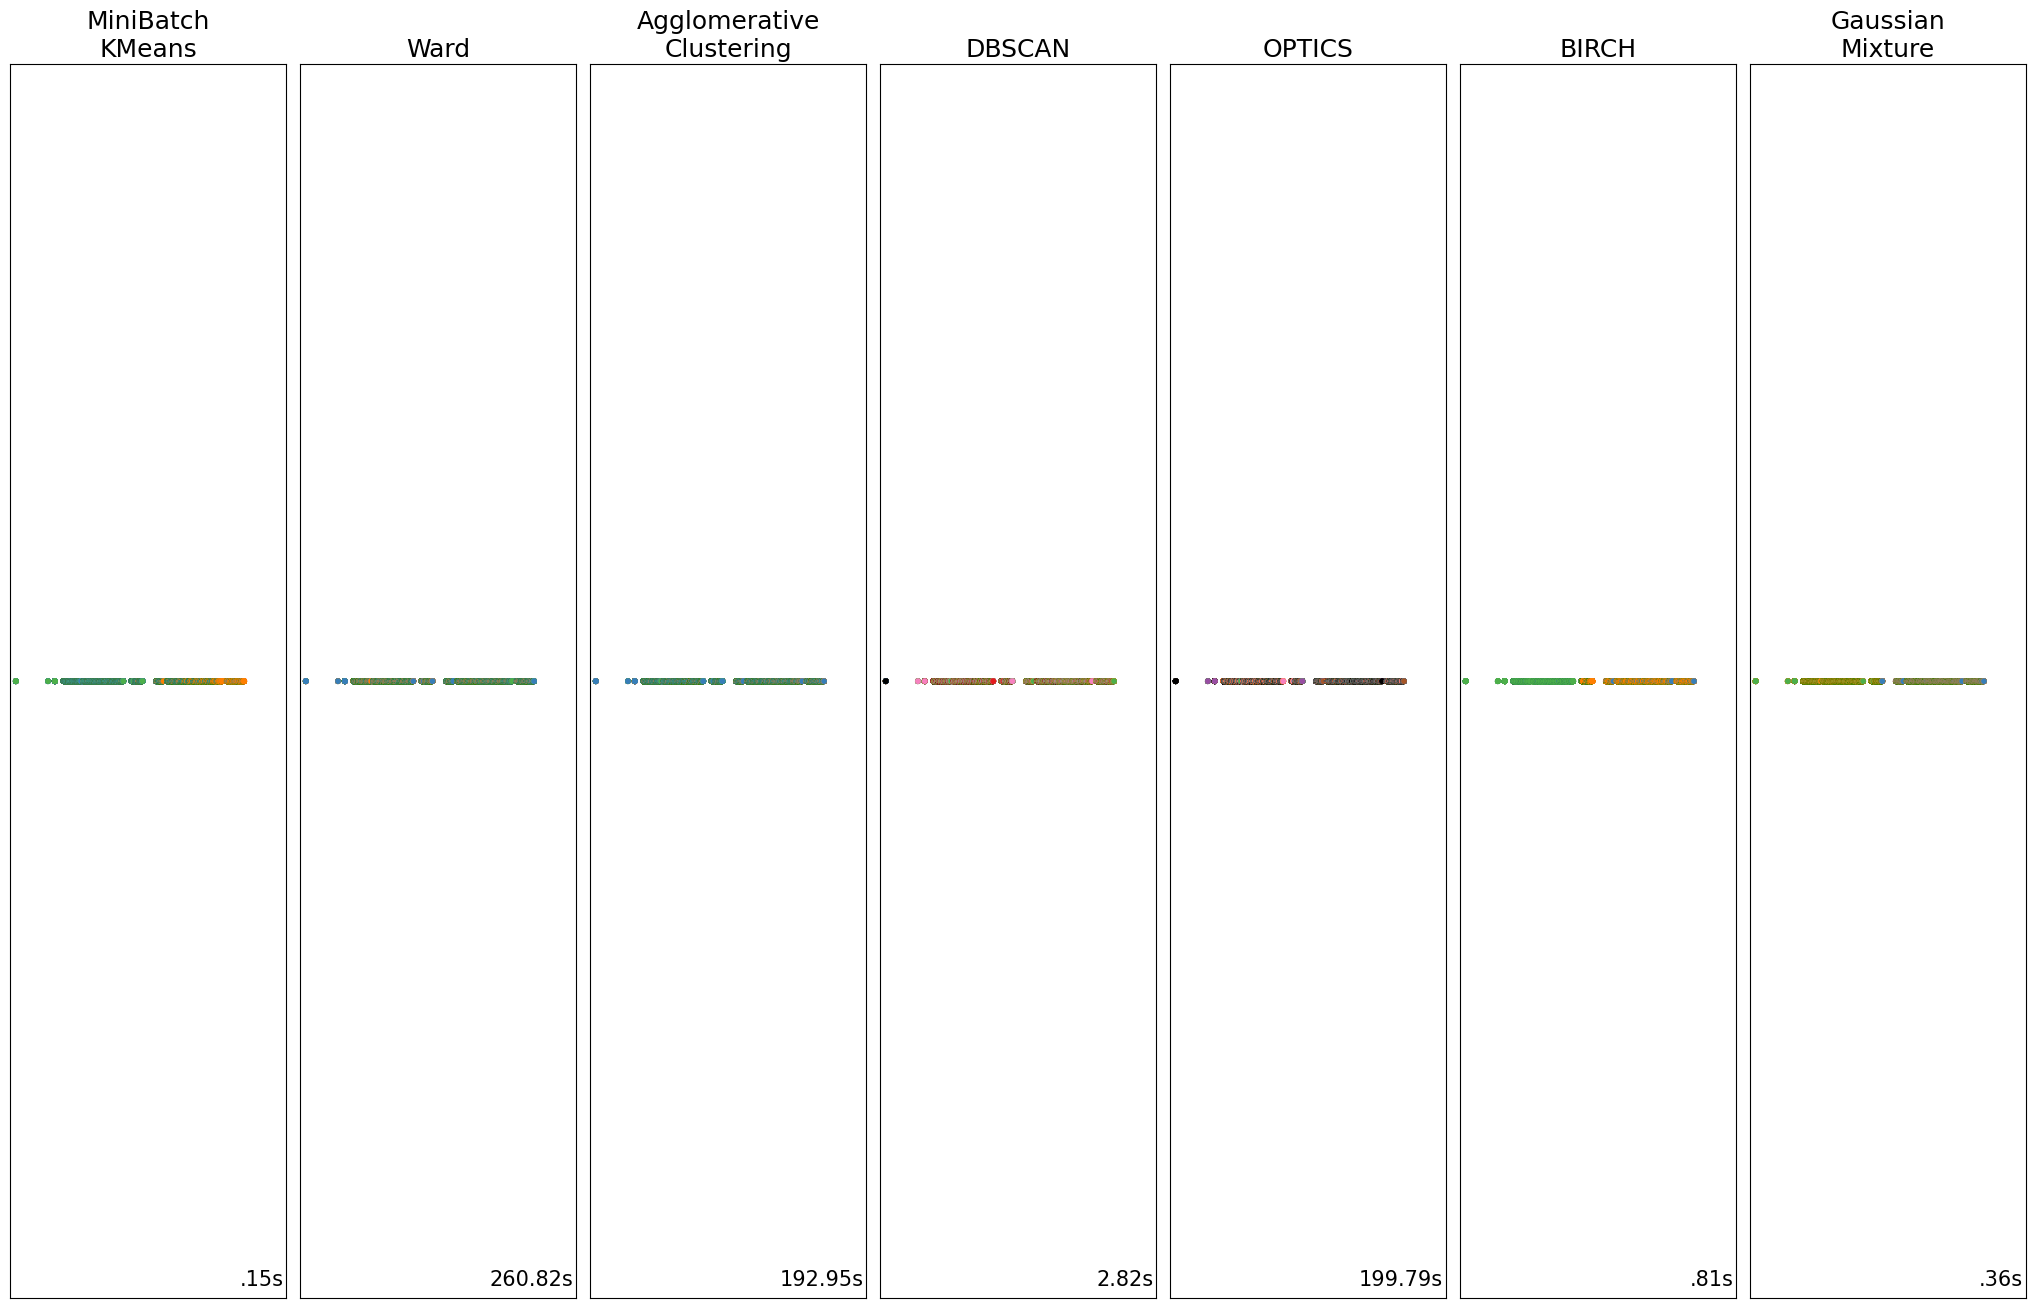

In [ ]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500

blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
#piso = piso.to_numpy().tolist()
#no_structure = np.random.rand(n_samples, 2), None
no_structure = piso, 6
# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.95, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .8,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}


datasets = [
#    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.2 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatch\nKMeans', two_means),
        ('Ward', ward),
        ('Agglomerative\nClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('BIRCH', birch),
        ('Gaussian\nMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

Otro ejemplo para los **PISOS**

In [ ]:
import pandas as pd

piso1=pd.read_csv('data_8.csv', sep=',' )

In [ ]:
piso1.head()

,Unnamed: 0,state,timestamp,id_house,id_sensor
0,0,on,1.674048e+09,8,46
1,1,off,1.674048e+09,8,46
2,2,on,1.674048e+09,8,45
3,3,off,1.674048e+09,8,45
4,4,on,1.674053e+09,8,48


In [ ]:
piso1=piso1.drop(['Unnamed: 0'], axis=1)

In [ ]:
piso=piso1

In [ ]:


piso['state_bool'] = piso.state.apply(lambda q: 1 if q == 'on' else 0)


In [ ]:
piso.shape

(59905, 5)

In [ ]:
piso=piso.drop('state', axis=1)

In [ ]:
# es el mismo piso
piso=piso.drop('id_house', axis=1)

In [ ]:
piso.head()

,timestamp,id_sensor,state_bool
0,1.674048e+09,46,1
1,1.674048e+09,46,0
2,1.674048e+09,45,1
3,1.674048e+09,45,0
4,1.674053e+09,48,1


Vamos a intentar hacer lo de voronoi con estos datos

Visualize the results on PCA-reduced data¶


In [ ]:
x = piso.iloc[:, [0, 1, 3]].values

In [ ]:
x[:3,:]

array([[1.67404840e+09, 1.00000000e+00],
       [1.67404841e+09, 0.00000000e+00],
       [1.67404841e+09, 1.00000000e+00]])

In [ ]:
x = piso.iloc[:, [0, 2]].values

In [ ]:
#Finding the optimum number of clusters for k-means classification
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 6, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(x)

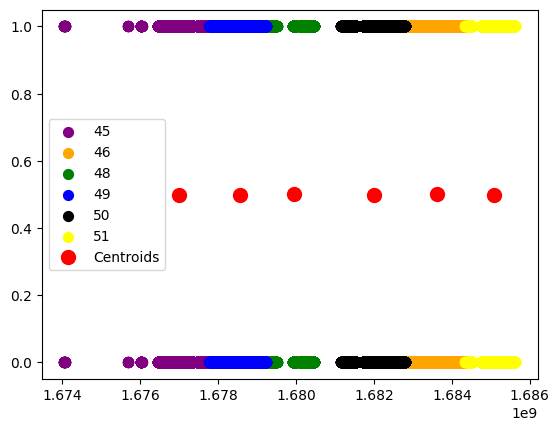

In [ ]:
import matplotlib.pyplot as plt

#Visualising the clusters
plt.scatter(x[y_kmeans == 0, 0], x[y_kmeans == 0, 1], s = 50, c = 'purple', label = '45')
plt.scatter(x[y_kmeans == 1, 0], x[y_kmeans == 1, 1], s = 50, c = 'orange', label = '46')
plt.scatter(x[y_kmeans == 2, 0], x[y_kmeans == 2, 1], s = 50, c = 'green', label = '48')
plt.scatter(x[y_kmeans == 3, 0], x[y_kmeans == 3, 1], s = 50, c = 'blue', label = '49')
plt.scatter(x[y_kmeans == 4, 0], x[y_kmeans == 4, 1], s = 50, c = 'black', label = '50')
plt.scatter(x[y_kmeans == 5, 0], x[y_kmeans == 5, 1], s = 50, c = 'yellow', label = '51')

#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s = 100, c = 'red', label = 'Centroids')

plt.legend()

Las gráficas no son muy "bonitas" y explican/visualizan poco.

Cosas que se pueden intentar, algo de preprocesamiento:

El procesamiento previo posible, sería, para cada evento, echar un espacio temporal para atrás y ver qué sensores se han activado y en función de eso, establecer reglas para cada actividad de manera personalizada. Así, vamos recorriendo los flujos de datos y vamos viendo si cumple o no cumple la regla.

Una posible opción, es que para cada día, en un periodo de tiempo, por ejemplo, cada hora, ver qué sensores se activan y ver si esa información se repite a lo largo de los días siendo rutina.

De este modo, salen los datos aislados por días y se podrían ver los cambios en rutinas.
